<div style="text-align: center"> <h1>Mean Baseline Aggregator and Classification Model</h1></div>

<div style="text-align: left"> <h3>We test different algorithms for classification after finding the mean np array for each of the 434 samples we have in the form (patient number_epileptic episode number_large/small view)</h3></div>

In [1]:
#Libraries
import pandas as pd
import numpy as np
import torch
import os
import torchvision
from torch import utils
import torch.nn as nn
from torch.utils import data
from torch.utils.data import Dataset
import torchvision
from torchvision import datasets
from torchvision.datasets import DatasetFolder
from torch.utils.data import DataLoader
#add seaborn module for graphs and etc. regarding the classifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

In [2]:
#KNN Classifier
from sklearn.neighbors import KNeighborsClassifier
#Logistic Regression
from sklearn.linear_model import LogisticRegression
#Desicion Tree
from sklearn.tree import DecisionTreeClassifier
#Random Forest
from sklearn.ensemble import RandomForestClassifier
#Support Vector Machine
from sklearn.svm import SVC
#Naive Bayers
from sklearn.naive_bayes import GaussianNB
#we want to add some classifiers on this model 
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier, VotingClassifier
#Scaler
from sklearn.preprocessing import StandardScaler
#Split
from sklearn.model_selection import train_test_split, cross_val_score, validation_curve, learning_curve
#Accuracy Score Metric
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
#pipeline for logistic regression classifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import ShuffleSplit
#Cross validation 
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std

<div style="text-align: left"> <h3>Mean Baseline Aggregation Step</h3></div>

In [3]:
#We have y meaning what we would like to predict and x is the predictors 
#and our predictors is the feature vectors we extracted from our pretained CNN

# x in mean baseline aggregation is average feature vectors
#Μάλλον δεν ήταν καλή ιδέα να βρούμε το average της λίστας των feature vectors
#θα βρώ αθρίσω τους feature vectors και θα τους διαιρέσω με το πλήθος τους
#p = r"features_fpc_8_fps_15"
#os.mkdir("mba/") #create a directory for mean baseline aggregator
#for folder in os.listdir(p):
 #   f = os.path.join(p, folder)
  #  if os.path.isdir(f):
   #     s = np.zeros(512)
    #    counter = 0
     #   for feat_vec in os.listdir(f):
      #      t = os.path.join(f, feat_vec)
       #     vec = torch.load(p+'/'+folder+'/'+feat_vec) #load each vector
        #    vec = vec.numpy() #turning each tensor to numpy array            
         #   s = np.add(s, vec) #keep the aggregation of all feature vectors in a folder represent large or small view of seizure
          #  counter = counter + 1 #keep how many feature vectors represent the view
            
    #av = s / counter 
    #av_vec = np.save('mba/'+folder+'_average.npy', av)

In [4]:
av_array = np.load('mba/030_02_L_average.npy')
print(av_array)
#mba stands for mean baseline aggregator

[0.80573549 1.75627408 0.73572741 0.34125502 0.09718032 1.08343956
 0.3247905  0.40239627 0.6064396  0.47286656 0.3260112  0.77627225
 0.29286558 0.80331253 0.3194959  0.67238537 0.12523341 0.26634707
 1.05242044 0.86226834 1.11264797 0.79546296 0.71946108 1.38167551
 1.48602105 0.39981495 1.63833926 2.04905452 0.26081308 1.32071959
 0.49361028 0.26188179 1.14433644 0.7541155  1.32027442 1.21194902
 0.79273511 0.52555548 1.5240677  0.92726256 1.19267878 1.41805038
 1.9954092  0.66396571 0.72423098 1.55533289 1.65165961 0.31687049
 2.39991881 0.31679899 0.69183243 0.43824668 0.49786703 2.17389881
 1.39540052 1.08428315 0.11626802 0.53575595 0.87626588 1.1846998
 0.43974598 1.3985597  0.13873972 0.62850884 0.74073505 1.03623362
 0.46223999 0.65097047 2.6557976  1.54977009 0.33842235 0.29614849
 0.78544275 0.12573167 0.34566408 0.78519491 0.33883397 1.23692269
 1.44776413 0.19371193 1.62124265 1.36414918 0.33500346 0.51380889
 0.5433228  0.6634291  0.23058667 0.29802861 0.43406322 0.44770

<div style="text-align: left"> <h3>Setting y as the classification target</h3></div>

In [5]:
#Διαβάζω το csv αρχείο μας
df = pd.read_csv("seizures.csv")
#Εκτυπώνω το dataframe που δημιουργείται
df

,Subject,Seizure,OnsetClonic,GTCS,Discard
0,6,1,37.0,True,No
1,6,2,NaN,False,No
2,12,1,42.0,True,No
3,15,1,96.0,True,No
4,16,1,39.0,True,No
...,...,...,...,...,...
215,321,12,NaN,False,No
216,321,13,NaN,False,No
217,321,14,NaN,False,No
218,321,15,57.0,True,Small


In [6]:
#We want to predict GTCS column
# 1: True (TCS-Generalized)
# 0: False (FOS-Focal)

print(df.dtypes) # let's see all the columns' data types at first

Subject          int64
Seizure          int64
OnsetClonic    float64
GTCS              bool
Discard         object
dtype: object


In [7]:
df1 = df.copy()                                      # Create copy of DataFrame
df1['GTCS'] = df1['GTCS'].astype(int)                    # Transform boolean to integer
print(df1)                                           # Print updated pandas DataFrame
df1.to_csv('seizures2.csv')  

     Subject  Seizure  OnsetClonic  GTCS Discard
0          6        1         37.0     1      No
1          6        2          NaN     0      No
2         12        1         42.0     1      No
3         15        1         96.0     1      No
4         16        1         39.0     1      No
..       ...      ...          ...   ...     ...
215      321       12          NaN     0      No
216      321       13          NaN     0      No
217      321       14          NaN     0      No
218      321       15         57.0     1   Small
219      321       16          NaN     0      No

[220 rows x 5 columns]


In [8]:
dfr = pd.read_csv("seizures2.csv")
dfr.drop(columns=dfr.columns[0], axis=1, inplace=True)
dfr

,Subject,Seizure,OnsetClonic,GTCS,Discard
0,6,1,37.0,1,No
1,6,2,NaN,0,No
2,12,1,42.0,1,No
3,15,1,96.0,1,No
4,16,1,39.0,1,No
...,...,...,...,...,...
215,321,12,NaN,0,No
216,321,13,NaN,0,No
217,321,14,NaN,0,No
218,321,15,57.0,1,Small


In [9]:
print(list(df1.columns))

['Subject', 'Seizure', 'OnsetClonic', 'GTCS', 'Discard']


In [10]:
print(df1.dtypes) # let's see all the columns' data types now

Subject          int64
Seizure          int64
OnsetClonic    float64
GTCS             int32
Discard         object
dtype: object


In [11]:
classes = df1['GTCS'].unique()
print(classes)

[1 0]


In [12]:
y = df1['GTCS'].values

In [13]:
y

array([1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [14]:
y.size

220

In [15]:
#Delete what's missing in accordance of our feature dataset and use np.repeat to duplicate
y.item(11)
y = np.delete(y, [11, 66, 195])

In [16]:
y

array([1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [17]:
y.size

217

In [18]:
y = np.repeat(y, 2)
y

array([1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0,

In [19]:
y.size

434

In [20]:
data = r"mba/"
X = np.array([np.load(data+arr) for arr in os.listdir(data)])
print(X.shape)
print(X)

(434, 512)
[[0.48304136 1.10189844 1.07579724 ... 0.18435701 0.09290289 0.18385619]
 [0.83579721 1.32052517 0.82916049 ... 0.50660639 0.27045454 0.0992175 ]
 [0.42507282 1.01574612 0.6624678  ... 0.13797588 0.07616863 0.1767677 ]
 ...
 [0.60668635 1.60228977 0.30032552 ... 0.32362048 0.17916517 0.61367639]
 [1.08576599 0.59754669 0.37895573 ... 0.02069822 0.0974206  0.5630052 ]
 [0.37964468 1.39534089 0.16932022 ... 0.64082903 0.09500065 0.08370053]]


In [21]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [22]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.3)

In [23]:
# Scale the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

<div style="text-align: left"> <h3>I set classifiers that I will use, their optimized versions of course.</h3></div>

In [24]:
#some tries for classification report displays
labels = np.arange(2)
target_names = list("01")

# Cross Validation Procedure
### 10-fold Cross Validation vs Stratified K-fold Cross Validation

In [25]:
# prepare the cross-validation procedure
cv = KFold(n_splits=10, random_state=1, shuffle=True)

In [26]:
#stratified k fold cv
skf = StratifiedKFold(n_splits=2)

# 1. KNN Classifier

## Best k number of neighbors classifier with both splits

In [27]:
k_values = [i for i in range (1,30)]
scores = []

scaler = StandardScaler()
X = scaler.fit_transform(X)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X, y, cv=5)
    scores.append(np.mean(score))

Text(0, 0.5, 'Accuracy Score')

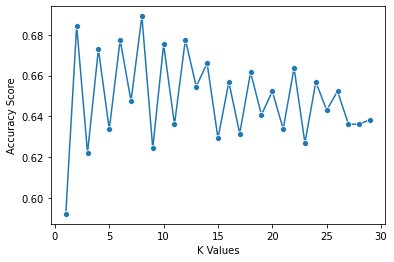

In [28]:
sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")

In [29]:
best_index = np.argmax(scores)
best_k = k_values[best_index]

bestk_knn = KNeighborsClassifier(n_neighbors=best_k)
bestk_knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=8)

In [30]:
y_pred4 = bestk_knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred4)
precision = precision_score(y_test, y_pred4)
recall = recall_score(y_test, y_pred4)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.7126436781609196
Precision: 0.5384615384615384
Recall: 0.75


Confusion Matrix:
[[41 18]
 [ 7 21]]
Classification Report:
{'0': {'precision': 0.8541666666666666, 'recall': 0.6949152542372882, 'f1-score': 0.7663551401869159, 'support': 59}, '1': {'precision': 0.5384615384615384, 'recall': 0.75, 'f1-score': 0.6268656716417911, 'support': 28}, 'accuracy': 0.7126436781609196, 'macro avg': {'precision': 0.6963141025641025, 'recall': 0.722457627118644, 'f1-score': 0.6966104059143534, 'support': 87}, 'weighted avg': {'precision': 0.7525604185086944, 'recall': 0.7126436781609196, 'f1-score': 0.7214619778965309, 'support': 87}}


<AxesSubplot:>

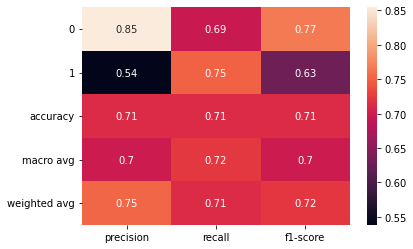

In [31]:
result = confusion_matrix(y_test, y_pred4)
print("Confusion Matrix:")
print(result)
result1 = classification_report(y_test, y_pred4, labels=labels, target_names=target_names, output_dict=True)
print("Classification Report:")
print (result1)
# .iloc[:-1, :] to exclude support
sns.heatmap(pd.DataFrame(result1).iloc[:-1, :].T, annot=True)

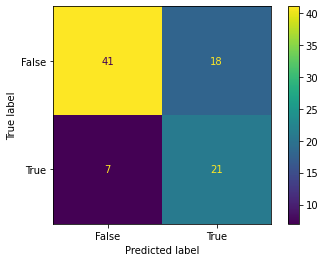

In [32]:
cm_display = metrics.ConfusionMatrixDisplay(result, display_labels = [False, True])
cm_display.plot()
plt.show()

In [33]:
bestk_knn.score(X_test,y_test) #mean accuracy on the given test data and labels

0.7126436781609196

In [34]:
#Cross validation 
# evaluate model
scores = cross_val_score(bestk_knn, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.642 (0.111)


In [35]:
#Cross validation 
# evaluate model
scores = cross_val_score(bestk_knn, X_test, y_test, scoring='accuracy', cv=skf, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.610 (0.110)


# 2. Logistic Regression

In [36]:
pipeline = make_pipeline(LogisticRegression(solver='lbfgs', penalty='l2', max_iter=10000, random_state=1))
pipeline.fit(X_train, y_train)
y_pred10 = pipeline.predict(X_test)

In [37]:
accuracy = accuracy_score(y_test, y_pred10)
print("Accuracy:", accuracy)

Accuracy: 0.7931034482758621


Confusion Matrix:
[[50  9]
 [ 9 19]]
Classification Report:
{'0': {'precision': 0.847457627118644, 'recall': 0.847457627118644, 'f1-score': 0.847457627118644, 'support': 59}, '1': {'precision': 0.6785714285714286, 'recall': 0.6785714285714286, 'f1-score': 0.6785714285714286, 'support': 28}, 'accuracy': 0.7931034482758621, 'macro avg': {'precision': 0.7630145278450363, 'recall': 0.7630145278450363, 'f1-score': 0.7630145278450363, 'support': 87}, 'weighted avg': {'precision': 0.7931034482758621, 'recall': 0.7931034482758621, 'f1-score': 0.7931034482758621, 'support': 87}}


<AxesSubplot:>

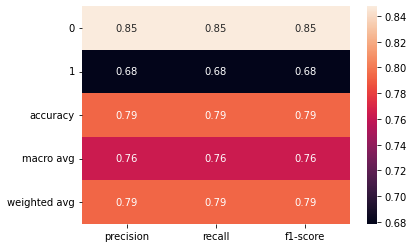

In [38]:
result = confusion_matrix(y_test, y_pred10)
print("Confusion Matrix:")
print(result)
result1 = classification_report(y_test, y_pred10, labels=labels, target_names=target_names, output_dict=True)
print("Classification Report:")
print (result1)
sns.heatmap(pd.DataFrame(result1).iloc[:-1, :].T, annot=True)

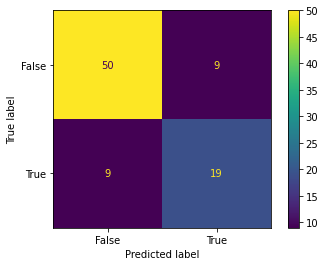

In [39]:
cm_display = metrics.ConfusionMatrixDisplay(result, display_labels = [False, True])
cm_display.plot()
plt.show()

In [40]:
#Cross validation 
# evaluate model
scores = cross_val_score(pipeline, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.676 (0.092)


In [41]:
# Stratified Cross validation 
# evaluate model
scores = cross_val_score(pipeline, X_test, y_test, scoring='accuracy', cv=skf, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.678 (0.019)


# 3. Desicion Tree 

In [42]:
dtc = DecisionTreeClassifier(criterion="entropy", max_depth=3) #optimizing
dtc.fit(X_train, y_train)
y_pred6 = dtc.predict(X_test)

In [43]:
accuracy = accuracy_score(y_test, y_pred6)
print("Accuracy:", accuracy)

Accuracy: 0.735632183908046


Confusion Matrix:
[[43 16]
 [ 7 21]]
Classification Report:
{'0': {'precision': 0.86, 'recall': 0.7288135593220338, 'f1-score': 0.7889908256880733, 'support': 59}, '1': {'precision': 0.5675675675675675, 'recall': 0.75, 'f1-score': 0.6461538461538462, 'support': 28}, 'accuracy': 0.735632183908046, 'macro avg': {'precision': 0.7137837837837837, 'recall': 0.7394067796610169, 'f1-score': 0.7175723359209598, 'support': 87}, 'weighted avg': {'precision': 0.7658838148493321, 'recall': 0.735632183908046, 'f1-score': 0.7430203035391266, 'support': 87}}


<AxesSubplot:>

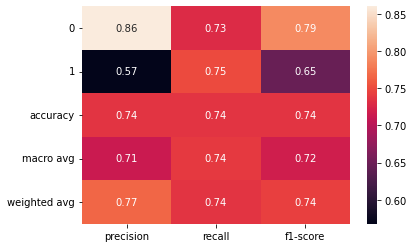

In [44]:
result = confusion_matrix(y_test, y_pred6)
print("Confusion Matrix:")
print(result)
result1 = classification_report(y_test, y_pred6, labels=labels, target_names=target_names, output_dict=True)
print("Classification Report:")
print (result1)
sns.heatmap(pd.DataFrame(result1).iloc[:-1, :].T, annot=True)

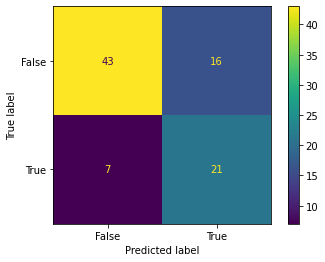

In [45]:
cm_display = metrics.ConfusionMatrixDisplay(result, display_labels = [False, True])
cm_display.plot()
plt.show()

In [46]:
#Cross validation 
# evaluate model
scores = cross_val_score(dtc, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.676 (0.131)


In [47]:
# Stratified Cross validation 
# evaluate model
scores = cross_val_score(dtc, X_test, y_test, scoring='accuracy', cv=skf, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.677 (0.073)


# 4. Random Forest

In [48]:
rfc = RandomForestClassifier(random_state = 1, max_depth = 15, n_estimators = 500, min_samples_split = 2, min_samples_leaf = 1)
rfc.fit(X_train, y_train)
y_pred7 = rfc.predict(X_test)

In [49]:
accuracy = accuracy_score(y_test, y_pred7)
print("Accuracy:", accuracy)

Accuracy: 0.8045977011494253


Confusion Matrix:
[[54  5]
 [12 16]]
Classification Report:
{'0': {'precision': 0.8181818181818182, 'recall': 0.9152542372881356, 'f1-score': 0.8640000000000001, 'support': 59}, '1': {'precision': 0.7619047619047619, 'recall': 0.5714285714285714, 'f1-score': 0.6530612244897959, 'support': 28}, 'accuracy': 0.8045977011494253, 'macro avg': {'precision': 0.7900432900432901, 'recall': 0.7433414043583535, 'f1-score': 0.758530612244898, 'support': 87}, 'weighted avg': {'precision': 0.8000696621386277, 'recall': 0.8045977011494253, 'f1-score': 0.7961116584564861, 'support': 87}}


<AxesSubplot:>

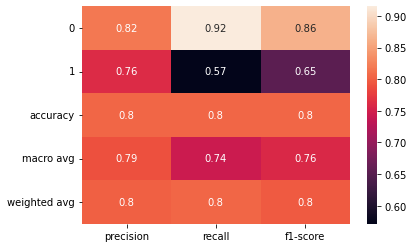

In [50]:
result = confusion_matrix(y_test, y_pred7)
print("Confusion Matrix:")
print(result)
result1 = classification_report(y_test, y_pred7, labels=labels, target_names=target_names, output_dict=True)
print("Classification Report:")
print (result1)
sns.heatmap(pd.DataFrame(result1).iloc[:-1, :].T, annot=True)

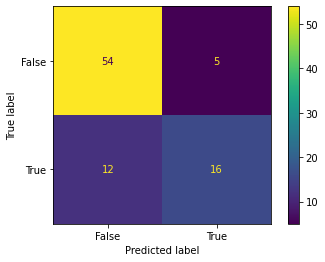

In [51]:
cm_display = metrics.ConfusionMatrixDisplay(result, display_labels = [False, True])
cm_display.plot()
plt.show()

In [52]:
#Cross validation 
# evaluate model
scores = cross_val_score(rfc, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.713 (0.174)


In [53]:
# Stratified Cross validation 
# evaluate model
scores = cross_val_score(rfc, X_test, y_test, scoring='accuracy', cv=skf, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.690 (0.008)


# 5. Support Vector Machine

In [54]:
svc = SVC(kernel='linear', C=0.025)
svc.fit(X_train, y_train)
y_pred8 = svc.predict(X_test)

In [55]:
accuracy = accuracy_score(y_test, y_pred8)
print("Accuracy:", accuracy)

Accuracy: 0.7816091954022989


Confusion Matrix:
[[48 11]
 [ 8 20]]
Classification Report:
{'0': {'precision': 0.8571428571428571, 'recall': 0.8135593220338984, 'f1-score': 0.8347826086956522, 'support': 59}, '1': {'precision': 0.6451612903225806, 'recall': 0.7142857142857143, 'f1-score': 0.6779661016949152, 'support': 28}, 'accuracy': 0.7816091954022989, 'macro avg': {'precision': 0.7511520737327189, 'recall': 0.7639225181598064, 'f1-score': 0.7563743551952837, 'support': 87}, 'weighted avg': {'precision': 0.788918904602998, 'recall': 0.7816091954022989, 'f1-score': 0.784312928281622, 'support': 87}}


<AxesSubplot:>

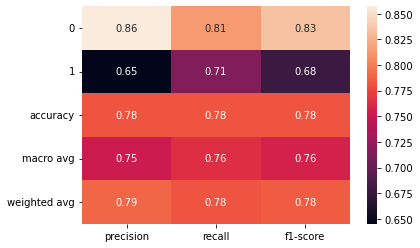

In [56]:
result = confusion_matrix(y_test, y_pred8)
print("Confusion Matrix:")
print(result)
result1 = classification_report(y_test, y_pred8, labels=labels, target_names=target_names, output_dict=True)
print("Classification Report:")
print (result1)
sns.heatmap(pd.DataFrame(result1).iloc[:-1, :].T, annot=True)

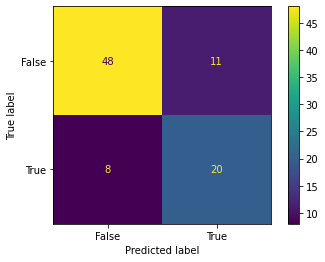

In [57]:
cm_display = metrics.ConfusionMatrixDisplay(result, display_labels = [False, True])
cm_display.plot()
plt.show()

In [58]:
#Cross validation 
# evaluate model
scores = cross_val_score(svc, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.675 (0.114)


In [59]:
# Stratified Cross validation 
# evaluate model
scores = cross_val_score(svc, X_test, y_test, scoring='accuracy', cv=skf, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.678 (0.019)


# 6. Naive Bayers

In [60]:
gnb = GaussianNB(var_smoothing=2e-9)
gnb.fit(X_train, y_train)
y_pred9 = gnb.predict(X_test)

In [61]:
accuracy = accuracy_score(y_test, y_pred9)
print("Accuracy:", accuracy)

Accuracy: 0.7126436781609196


Confusion Matrix:
[[40 19]
 [ 6 22]]
Classification Report:
{'0': {'precision': 0.8695652173913043, 'recall': 0.6779661016949152, 'f1-score': 0.7619047619047619, 'support': 59}, '1': {'precision': 0.5365853658536586, 'recall': 0.7857142857142857, 'f1-score': 0.6376811594202899, 'support': 28}, 'accuracy': 0.7126436781609196, 'macro avg': {'precision': 0.7030752916224814, 'recall': 0.7318401937046004, 'f1-score': 0.6997929606625259, 'support': 87}, 'weighted avg': {'precision': 0.7623992881607977, 'recall': 0.7126436781609196, 'f1-score': 0.7219247519097594, 'support': 87}}


<AxesSubplot:>

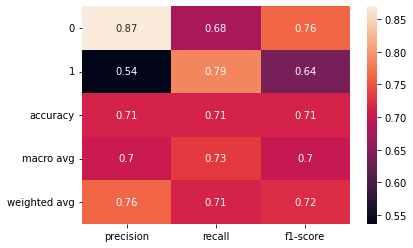

In [62]:
result = confusion_matrix(y_test, y_pred9)
print("Confusion Matrix:")
print(result)
result1 = classification_report(y_test, y_pred9, labels=labels, target_names=target_names, output_dict=True)
print("Classification Report:")
print (result1)
sns.heatmap(pd.DataFrame(result1).iloc[:-1, :].T, annot=True)

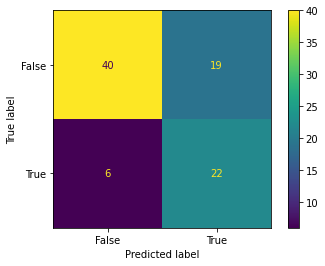

In [63]:
cm_display = metrics.ConfusionMatrixDisplay(result, display_labels = [False, True])
cm_display.plot()
plt.show()

In [64]:
#Cross validation 
# evaluate model
scores = cross_val_score(gnb, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.736 (0.123)


In [65]:
# Stratified Cross validation 
# evaluate model
scores = cross_val_score(gnb, X_test, y_test, scoring='accuracy', cv=skf, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.713 (0.031)


### The following algorithms are used for binary classification specifically and from the same module (ensemble) that our most effective algorithm Random Forest is. 

# 7. Gradient Boosting Classifier

In [66]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(X_train, y_train)
y_pred11 = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred11)
print("Accuracy:", accuracy)

Accuracy: 0.8390804597701149


Confusion Matrix:
[[51  8]
 [ 6 22]]
Classification Report:
{'0': {'precision': 0.8947368421052632, 'recall': 0.864406779661017, 'f1-score': 0.8793103448275862, 'support': 59}, '1': {'precision': 0.7333333333333333, 'recall': 0.7857142857142857, 'f1-score': 0.7586206896551724, 'support': 28}, 'accuracy': 0.8390804597701149, 'macro avg': {'precision': 0.8140350877192982, 'recall': 0.8250605326876513, 'f1-score': 0.8189655172413792, 'support': 87}, 'weighted avg': {'precision': 0.8427908852591247, 'recall': 0.8390804597701149, 'f1-score': 0.8404676971858898, 'support': 87}}


<AxesSubplot:>

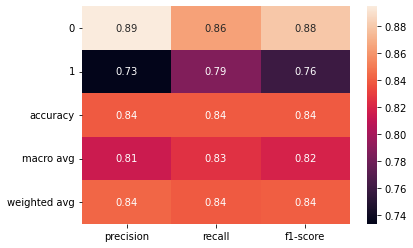

In [67]:
result = confusion_matrix(y_test, y_pred11)
print("Confusion Matrix:")
print(result)
result1 = classification_report(y_test, y_pred11, labels=labels, target_names=target_names, output_dict=True)
print("Classification Report:")
print (result1)
sns.heatmap(pd.DataFrame(result1).iloc[:-1, :].T, annot=True)

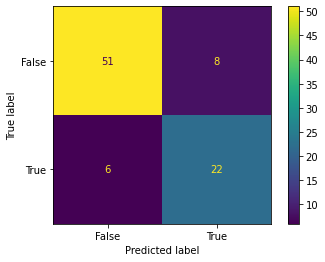

In [68]:
cm_display = metrics.ConfusionMatrixDisplay(result, display_labels = [False, True])
cm_display.plot()
plt.show()

In [69]:
#Cross validation 
# evaluate model
scores = cross_val_score(clf, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.690 (0.131)


In [70]:
# Stratified Cross validation 
# evaluate model
scores = cross_val_score(clf, X_test, y_test, scoring='accuracy', cv=skf, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.541 (0.041)


# 8. AdaBoost Classifier

In [71]:
clf2 = AdaBoostClassifier(n_estimators=100, algorithm="SAMME", random_state=0)
clf2.fit(X_train, y_train)
y_pred12 = clf2.predict(X_test)
accuracy = accuracy_score(y_test, y_pred12)
print("Accuracy:", accuracy)

Accuracy: 0.8045977011494253


Confusion Matrix:
[[53  6]
 [11 17]]
Classification Report:
{'0': {'precision': 0.828125, 'recall': 0.8983050847457628, 'f1-score': 0.8617886178861789, 'support': 59}, '1': {'precision': 0.7391304347826086, 'recall': 0.6071428571428571, 'f1-score': 0.6666666666666666, 'support': 28}, 'accuracy': 0.8045977011494253, 'macro avg': {'precision': 0.7836277173913043, 'recall': 0.7527239709443099, 'f1-score': 0.7642276422764227, 'support': 87}, 'weighted avg': {'precision': 0.7994830709645178, 'recall': 0.8045977011494253, 'f1-score': 0.7989907485281748, 'support': 87}}


<AxesSubplot:>

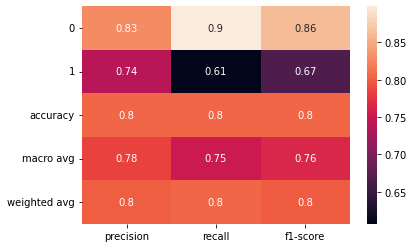

In [72]:
result = confusion_matrix(y_test, y_pred12)
print("Confusion Matrix:")
print(result)
result1 = classification_report(y_test, y_pred12, labels=labels, target_names=target_names, output_dict=True)
print("Classification Report:")
print (result1)
sns.heatmap(pd.DataFrame(result1).iloc[:-1, :].T, annot=True)

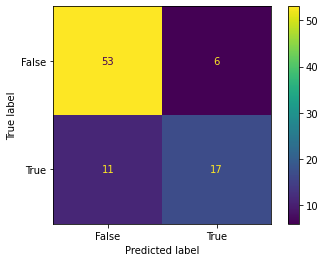

In [73]:
cm_display = metrics.ConfusionMatrixDisplay(result, display_labels = [False, True])
cm_display.plot()
plt.show()

In [74]:
#Cross validation 
# evaluate model
scores = cross_val_score(clf2, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.711 (0.095)


In [75]:
# Stratified Cross validation 
# evaluate model
scores = cross_val_score(clf2, X_test, y_test, scoring='accuracy', cv=skf, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.667 (0.008)


# 9. Bagging Classifier

In [80]:
clf4 = BaggingClassifier(svc, n_estimators=10, random_state=0).fit(X_train, y_train)
y_pred14 = clf4.predict(X_test)
accuracy = accuracy_score(y_test, y_pred14)
print("Accuracy:", accuracy)

Accuracy: 0.8160919540229885


Confusion Matrix:
[[51  8]
 [ 8 20]]
Classification Report:
{'0': {'precision': 0.864406779661017, 'recall': 0.864406779661017, 'f1-score': 0.864406779661017, 'support': 59}, '1': {'precision': 0.7142857142857143, 'recall': 0.7142857142857143, 'f1-score': 0.7142857142857143, 'support': 28}, 'accuracy': 0.8160919540229885, 'macro avg': {'precision': 0.7893462469733656, 'recall': 0.7893462469733656, 'f1-score': 0.7893462469733656, 'support': 87}, 'weighted avg': {'precision': 0.8160919540229885, 'recall': 0.8160919540229885, 'f1-score': 0.8160919540229885, 'support': 87}}


<AxesSubplot:>

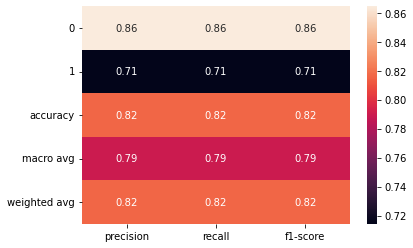

In [81]:
result = confusion_matrix(y_test, y_pred14)
print("Confusion Matrix:")
print(result)
result1 = classification_report(y_test, y_pred14, labels=labels, target_names=target_names, output_dict=True)
print("Classification Report:")
print (result1)
sns.heatmap(pd.DataFrame(result1).iloc[:-1, :].T, annot=True)

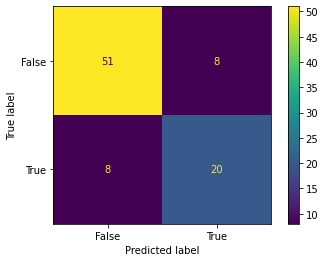

In [82]:
cm_display = metrics.ConfusionMatrixDisplay(result, display_labels = [False, True])
cm_display.plot()
plt.show()

In [83]:
#Cross validation 
# evaluate model
scores = cross_val_score(clf4, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.653 (0.121)


In [84]:
# Stratified Cross validation 
# evaluate model
scores = cross_val_score(clf4, X_test, y_test, scoring='accuracy', cv=skf, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.678 (0.004)


# 10. Voting Classifier

In [85]:
#There are two modes for this one  
eclf1 = VotingClassifier(estimators=[('lr', pipeline), ('rf', rfc), ('gnb', gnb)], voting='hard')
eclf1.fit(X_train, y_train)
y_pred15 = eclf1.predict(X_test)
accuracy = accuracy_score(y_test, y_pred15)
print("Accuracy:", accuracy)

Accuracy: 0.8160919540229885


Confusion Matrix:
[[50  9]
 [ 7 21]]
Classification Report:
{'0': {'precision': 0.8771929824561403, 'recall': 0.847457627118644, 'f1-score': 0.8620689655172413, 'support': 59}, '1': {'precision': 0.7, 'recall': 0.75, 'f1-score': 0.7241379310344827, 'support': 28}, 'accuracy': 0.8160919540229885, 'macro avg': {'precision': 0.7885964912280701, 'recall': 0.798728813559322, 'f1-score': 0.793103448275862, 'support': 87}, 'weighted avg': {'precision': 0.820165355918532, 'recall': 0.8160919540229885, 'f1-score': 0.8176773682124455, 'support': 87}}


<AxesSubplot:>

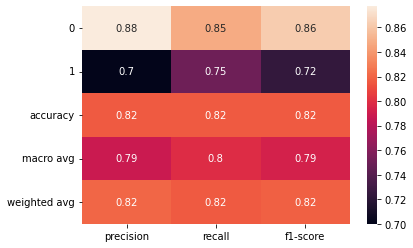

In [86]:
result = confusion_matrix(y_test, y_pred15)
print("Confusion Matrix:")
print(result)
result1 = classification_report(y_test, y_pred15, labels=labels, target_names=target_names, output_dict=True)
print("Classification Report:")
print (result1)
sns.heatmap(pd.DataFrame(result1).iloc[:-1, :].T, annot=True)

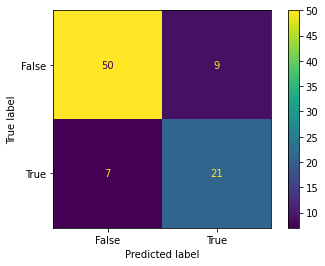

In [87]:
cm_display = metrics.ConfusionMatrixDisplay(result, display_labels = [False, True])
cm_display.plot()
plt.show()

In [88]:
#Cross validation 
# evaluate model
scores = cross_val_score(eclf1, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.757 (0.120)


In [89]:
# Stratified Cross validation 
# evaluate model
scores = cross_val_score(eclf1, X_test, y_test, scoring='accuracy', cv=skf, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.724 (0.003)


<div style="text-align: left"> <h3>The algorithm with the most satisfying F1-score is the same as this one which has the best accuracy rate. This algorithm is the Gradient Boosting Classifier, which appears not to maintain its position in the hierarchy in the process. In Cross Validation, the Voting Classifier algorithm and indeed its strict form (Hard Voting), seems in both cases to bring the highest score. The Gradient Boosting Classifier has some of the best performance but not the best.</h3></div>